In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import rasterio
from rasterio.plot import show, show_hist

In [2]:
base_dir = '/home/daric/dev/data/nigeria/geotiffs/'
mul_dir = 'multi_spectral'
#img_file = '19MAY27102816-{}2AS-014909258010_01_P001.TIF' # Invalid
#img_file = '19MAY27102817-{}2AS-014909262010_01_P001.TIF' # Invalid
#img_file = '20FEB22101135-{}2AS-014909251010_01_P001.TIF' # Valid
#img_file = '21FEB25101358-{}2AS-014909264010_01_P001.TIF' # Invalid
#img_file = '21NOV03101658-{}2AS-014909259010_01_P001.TIF' # Invalid
img_file = '21DEC30101738-{}2AS-014909260010_01_P001.TIF' # Valid
#img_file = '22JAN22102131-{}2AS-014909261010_01_P001.TIF' # Valid
mul_file = img_file.format('M')
img_path = os.path.join(base_dir, mul_dir, mul_file)
img = rasterio.open(img_path)
figsize = (12, 12)
fontsize = 25

In [3]:
blue_band = img.read(2)
green_band = img.read(3)
red_band = img.read(4)
nir_band = img.read(8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


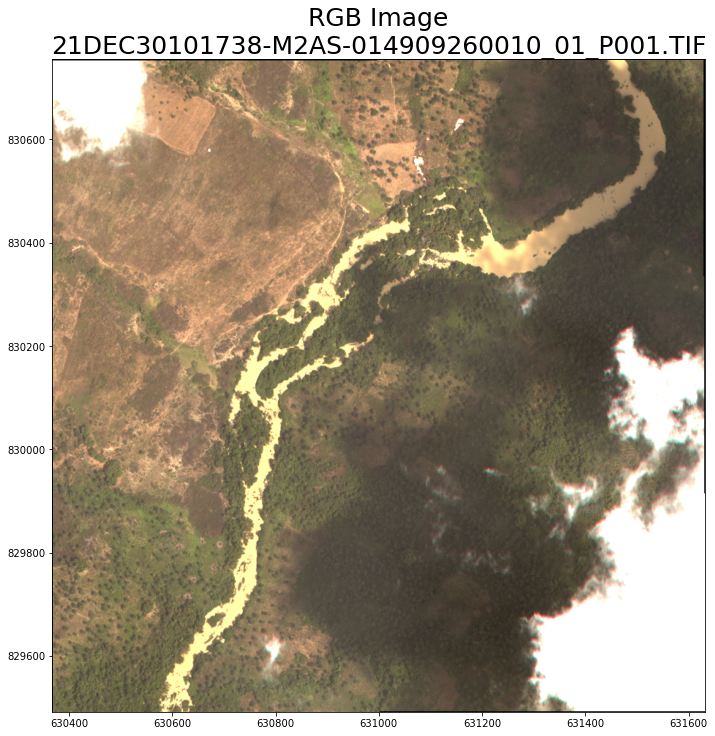

<AxesSubplot:title={'center':'RGB Image\n21DEC30101738-M2AS-014909260010_01_P001.TIF'}>

In [4]:
rgb_img = np.array([red_band, green_band, blue_band]).transpose(1,2,0)

# Plot the RGB image
plt.figure(figsize=figsize)
plt.title('RGB Image\n' + mul_file, fontsize=fontsize)
show(rgb_img.transpose(2,0,1), transform=img.transform)

In [5]:
# Normalized Difference Index
def compute_ndi(band_a, band_b):
    numerator = band_a - band_b
    denominator = band_a + band_b
    numerator[np.isclose(denominator, np.zeros(denominator.shape))] = 0
    denominator[np.isclose(denominator, np.zeros(denominator.shape))] = 1
    return numerator / denominator

In [6]:
# Normalized Difference Water Index (NDWI)
ndwi = compute_ndi(green_band, nir_band)
water_thresh = 0.3
water_mask = np.ma.masked_greater_equal(ndwi, water_thresh)

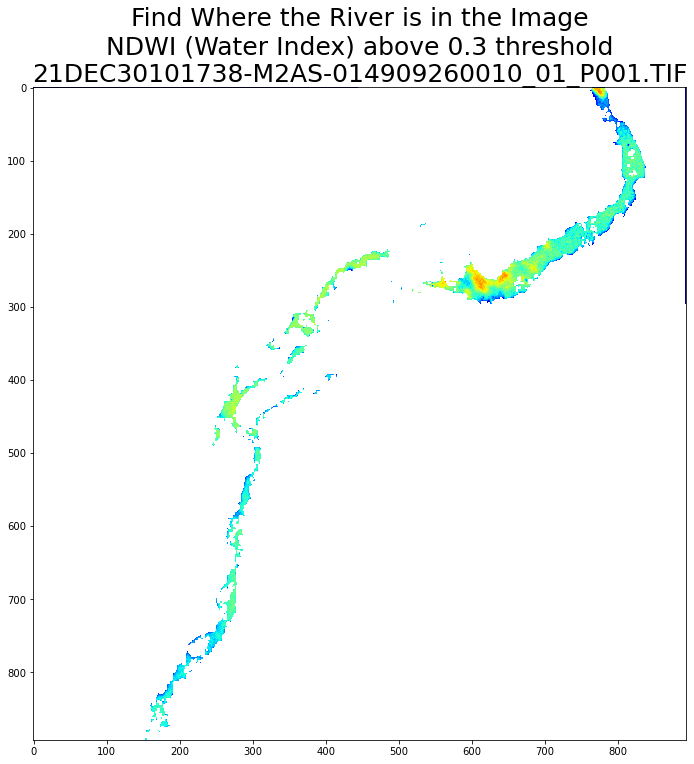

In [7]:
plt.figure(figsize=figsize)
plt.title('Find Where the River is in the Image\nNDWI (Water Index) above ' + str(water_thresh) + ' threshold\n' + mul_file, fontsize=fontsize)
plt.imshow(water_mask, cmap='jet')

In [8]:
# Normalized Difference turbidity Index (NDTI)
ndti = compute_ndi(red_band, green_band)
turbid_mask = np.ma.masked_array(ndti, mask=water_mask.mask)

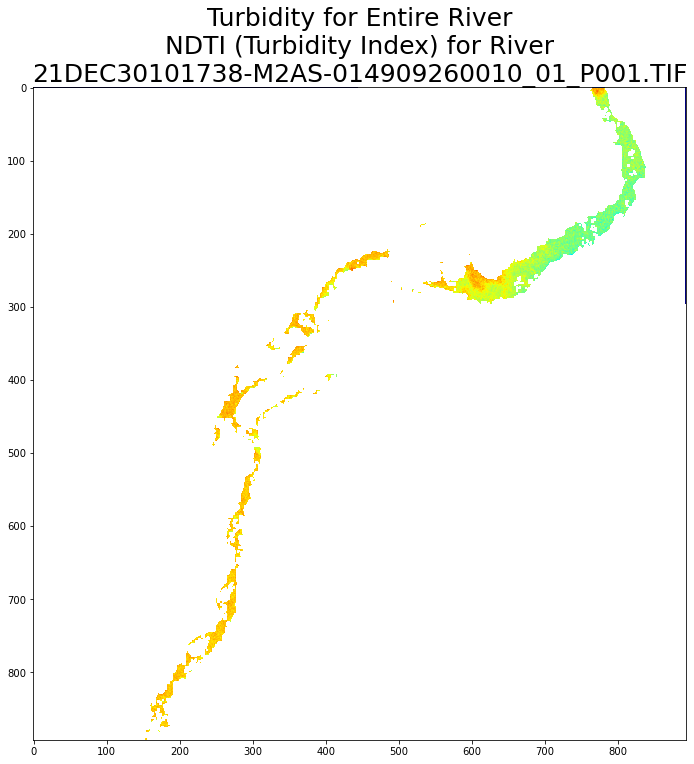

In [9]:
plt.figure(figsize=figsize)
plt.title('Turbidity for Entire River\nNDTI (Turbidity Index) for River\n' + mul_file, fontsize=fontsize)
plt.imshow(turbid_mask, cmap='jet')

In [10]:
quant = 0.9
high_turbid_mask = np.ma.masked_less(turbid_mask, np.quantile(turbid_mask, quant))

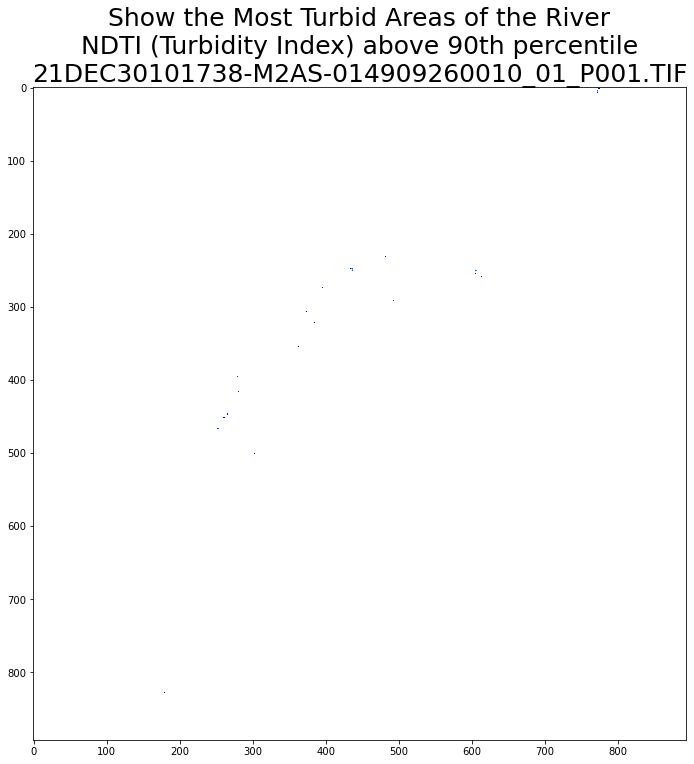

In [11]:
plt.figure(figsize=figsize)
plt.title('Show the Most Turbid Areas of the River\nNDTI (Turbidity Index) above ' + str(int(quant * 100)) + 'th percentile\n' + mul_file, fontsize=fontsize)
plt.imshow(high_turbid_mask, cmap='jet')

In [12]:
red_mask = np.ma.masked_array(red_band, mask=high_turbid_mask.mask)
pd.Series(red_mask[red_mask.mask==False]).describe()

count    3893.000000
mean      358.129463
std        25.040598
min       145.000000
25%       351.000000
50%       363.000000
75%       373.000000
max       429.000000
dtype: float64

In [13]:
green_mask = np.ma.masked_array(green_band, mask=high_turbid_mask.mask)
pd.Series(green_mask[green_mask.mask==False]).describe()

count    3893.00000
mean      271.16337
std        19.32555
min       111.00000
25%       266.00000
50%       275.00000
75%       283.00000
max       328.00000
dtype: float64

In [14]:
blue_mask = np.ma.masked_array(blue_band, mask=high_turbid_mask.mask)
pd.Series(blue_mask[blue_mask.mask==False]).describe()

count    3893.000000
mean      175.669407
std        11.560262
min        85.000000
25%       171.000000
50%       178.000000
75%       183.000000
max       224.000000
dtype: float64